## 패키지

In [ ]:
pip install pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 나눔 폰트 설치 (설치 후 런타임 재시작하고 코드 실행)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
plt.rc('font', family='NanumBarunGothic') # 한글 출력

## 데이터 로드

In [ ]:
# DB 연결
endpoint = 'dao.c51deksujiip.ap-northeast-2.rds.amazonaws.com'
schema_name = 'dao'
db_connection_str = 'mysql+pymysql://admin:ekfkawnl@{}/{}'.format(endpoint, schema_name )
try :
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()
except :
    print('fail to connect db')

In [ ]:
# 육교형 생태통로 MainData DF 가져오기
sql = "SELECT * FROM {}".format('MainData_overpass')
df_overpass = pd.read_sql(sql,db_connection)
df_overpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                300 non-null    int64  
 1   위도                300 non-null    float64
 2   경도                300 non-null    float64
 3   생태통로_유형           300 non-null    int64  
 4   차선_수              300 non-null    int64  
 5   등산객_이용빈도          300 non-null    int64  
 6   생태통로_효율성          300 non-null    int64  
 7   이용확인종_수           300 non-null    int64  
 8   폭(m)              249 non-null    float64
 9   연장(m)             249 non-null    float64
 10  경사도               300 non-null    object 
 11  주변 로드킬 빈도         300 non-null    int64  
 12  산책로까지의 최단 거리(km)  300 non-null    float64
 13  농가까지의 거리(km)      300 non-null    float64
 14  도로 최고제한속도(km/h)   300 non-null    int64  
 15  주변 동물종 개수         300 non-null    int64  
 16  주변동물 출현빈도         300 non-null    int64  
 1

In [ ]:
# 터널형 생태통로 MainData DF 가져오기
sql = "SELECT * FROM {}".format('MainData_tunnel')
df_tunnel = pd.read_sql(sql,db_connection)
df_tunnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                197 non-null    int64  
 1   위도                197 non-null    float64
 2   경도                197 non-null    float64
 3   생태통로_유형           197 non-null    int64  
 4   차선_수              197 non-null    int64  
 5   등산객_이용빈도          197 non-null    int64  
 6   생태통로_효율성          197 non-null    int64  
 7   이용확인종_수           197 non-null    int64  
 8   폭(m)              21 non-null     float64
 9   연장(m)             22 non-null     float64
 10  높이(m)             21 non-null     float64
 11  개방도               22 non-null     float64
 12  경사도               197 non-null    object 
 13  주변 로드킬 빈도         197 non-null    int64  
 14  산책로까지의 최단 거리(km)  197 non-null    float64
 15  농가까지의 거리(km)      197 non-null    float64
 16  도로 최고제한속도(km/h)   197 non-null    int64  
 1

## 이상치 확인

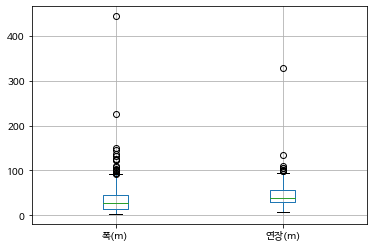

In [ ]:
# 육교형 생태통로 규격 데이터 Boxplot
df_overpass.boxplot(column=['폭(m)',  '연장(m)'])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


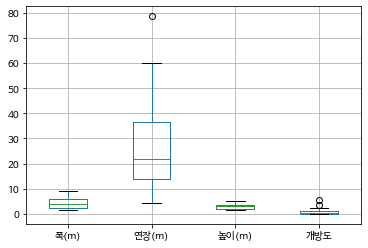

In [ ]:
# 터널형 생태통로 규격 데이터 Boxplot
df_tunnel.boxplot(column = ['폭(m)','연장(m)','높이(m)','개방도'])

=> 육교형, 터널형 생태통로 데이터 모두 이상치가 모두 비이상적으로 큰 값들이므로, 모두 Boxplot의 **상한값**으로 대체

## 이상치 처리
Boxplot의 상한값으로 대체

In [ ]:
# 규격 데이터의 이상치를 상한값으로 변경하는 함수
def change_outlier(df, col_list):
  for col_name in col_list:
    Q1 = df[col_name].quantile(q=0.25)
    Q3 = df[col_name].quantile(q=0.75)
    IQR = Q3-Q1
    idx = list(df[(df[col_name] > (Q3+1.5*IQR)) | (df[col_name] < (Q1-1.5*IQR))].index)
    # print(idx)
    df.loc[idx, col_name] = round(Q3+1.5*IQR, 1)
  return df


df_overpass=change_outlier(df_overpass, ['폭(m)','연장(m)']) #육교형
df_tunnel=change_outlier(df_tunnel, ['폭(m)','연장(m)','높이(m)','개방도']) #터널형

여기까지는 동일하게 처리

## 결측치 처리
규격 데이터(육교형 - 폭, 연장 / 터널형 - 폭, 연장, 높이, 개방도) 결측치 

### 1. 평균으로 대체

In [ ]:
# 규격 데이터의 결측치를 평균으로 대치하는 함수(평균)
def imputation_mean(df, col_list):
  for col_name in col_list:
    df[col_name].fillna(round(df[col_name].mean(),1), inplace=True)
  return df

# df_overpass=imputation_mean(df_overpass, ['폭(m)', '연장(m)']) #육교형
# df_tunnel=imputation_mean(df_tunnel, ['폭(m)','연장(m)','높이(m)','개방도']) #터널형

### 2. KNN으로 대체

In [ ]:
# KNN 알고리즘으로 결측값 대체 함수
from sklearn.impute import KNNImputer
def KNNImputation(df, col_list, n_neighbors):
  imputer = KNNImputer(n_neighbors=n_neighbors)
  filled = imputer.fit_transform(df[col_list])
  filled = np.round(filled, 1) # 소수점 한 자리 수까지 반올림
  df[col_list] = pd.DataFrame(filled)
  return df
  
df_overpass_knn2 = KNNImputation(df_overpass, ['폭(m)', '연장(m)'], 2)
df_overpass_knn3 = KNNImputation(df_overpass, ['폭(m)', '연장(m)'], 3)
df_tunnel_knn2 = KNNImputation(df_tunnel, ['폭(m)', '연장(m)', '높이(m)', '개방도'], 2)
df_tunnel_knn3 = KNNImputation(df_tunnel, ['폭(m)', '연장(m)', '높이(m)', '개방도'], 3)

## 생태통로 효율성 데이터 처리

### 1. '판단불가' 값을 '보통'으로 변경

In [ ]:
# 생태통로 효율성 데이터의 '판단불가'값을 중앙값('보통')으로 변경하는 함수
def change_median(df, col_name):
  df[df[col_name]==3]=1
  return df

df_overpass=change_median(df_overpass, '생태통로_효율성') #육교형
df_tunnel=change_median(df_tunnel, '생태통로_효율성') #터널형

### 2. '판단불가' 값을 삭제

In [ ]:
# 생태통로 효율성 데이터가 '판단불가'값이면 삭제하는 함수
def change_median(df, col_name):
  df.drop(df[df[col_name]==3].index, inplace=True)
  return df

# df_overpass=change_median(df_overpass, '생태통로_효율성') #육교형
# df_tunnel=change_median(df_tunnel, '생태통로_효율성') #터널형

## RDS에 데이터 업로드

In [ ]:
# MainData DF → DB
#table_name1 = 'MainData_outlier_overpass'
#table_name2 = 'MainData_outlier_tunnel'
#df_overpass.to_sql(name=table_name1, con=db_connection, if_exists='replace', index=False)
#df_tunnel.to_sql(name=table_name2, con=db_connection, if_exists='replace', index=False)